In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import pylab
import scipy.stats as ss
import csv
import numpy as np
import sklearn
import glob
from io import StringIO
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from collections import Counter

C:\Users\ywen2\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Para que sea más sencillo nombrar las variables, vamos a definir dos modelos, añadiremos rev2 para diferenciarlos de los modelos de la revisión 1:
- **Modelo 1 rev2**: eliminamos las variables Blood Glucose y Glycated-HB
- **Modelo 2 rev2**: eliminamos también Vitamin-D, HOMA, Insulin

# 1. PREPROCESADO:

- **Cargamos las matrices anteriormente creadas** y que fueron divididas en train y test. Cargamos tanto los pacientes con sus variables y revisiones como las etiquetas asociadas a cada paciente

In [2]:
X_train = np.load('Conjunto_train.npy')
X_test = np.load('Conjunto_test.npy')
y_train = np.load('Labels_train.npy')
y_test = np.load('Labels_test.npy')

- Cargamos las probabilidades de pertenecer a cada clase para imputarlas como nueva columna a la revisión 2.

In [3]:
Prob_train_without_BG_HB = np.load('Prob_train_review_1_all_features.npy')
Prob_test_without_BG_HB = np.load('Prob_test_review_1_all_features.npy')
Prob_train_1_without_BG_HB_VD_Ins_HOMA = np.load('Prob_train_review_1_without_homa_vit_d.npy')
Prob_test_1_without_BG_HB_VD_Ins_HOMA = np.load('Prob_test_review_1_without_homa_vit_d.npy')

- **Comprobamos las dimensiones de cada matriz**, tenemos 1317 pacientes para train y 330 para test (partición 80/20).

El 13 hace referencia al número de revisiones que nosotros mismos decicimos como idóneas. 22 son el número de features.

In [4]:
print(y_train.shape)
print(X_train.shape)
print(y_test.shape)
print(X_test.shape)

print(Prob_train_without_BG_HB.shape)  # los nombres de estas variables no son suficientemente claros, debes indicar en algún lado 
#qué diferencia hay entre prob_train y prob_train_1
print(Prob_test_without_BG_HB.shape)
print(Prob_train_1_without_BG_HB_VD_Ins_HOMA.shape)
print(Prob_test_1_without_BG_HB_VD_Ins_HOMA.shape)

#print(Prob_train[0])
#print(Prob_train_1[0])

(1317,)
(1317, 13, 22)
(330,)
(330, 13, 22)
(1317,)
(330,)
(1317,)
(330,)


- Como observamos el el histograma, los **datos están desbalanceados**.

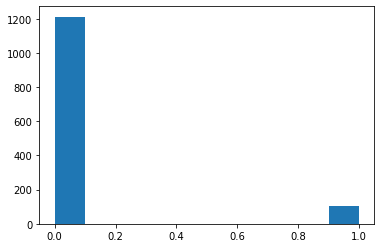

In [5]:
plt.hist(y_train)
plt.show()

In [6]:
X_train_2 = X_train[:,1,:]

Vamos a hacer lo siguiente en la función:

1. Revisar si hay alguna característica que tenga más del 50% a NaN, entonces habría que considerar eliminarla. Tenemos un problema, porque hay que revisar que tengo más de 50% en todas las revisiones. Para no complicar las cosas, vamos a considerar que trabajamos sólo con tres revisiones (vamos a ver si llegamos rápido a ese punto, en otro caso deberíamos ver si paramos en tres revisiones, que ya es bastante).

1. Revisar si hay algún paciente con más de 8 características NaN, con que esto ocurra en cualquiera de las tres revisiones, deberíamos considerarlo que se elimina, en todas las revisiones.

## 1.1 Features con problemas:

Revisando la información rápidamente hay varias features con problemas:

1. **Importante**: las variables *Blood_Glucose* y *Glycated-HB* hay que sacarlas fuera de la base de datos, porque son las que se utilizan para determinar si un pacientes diabético o no.
1. Hay cuatro variables que tiene muchos NaN, así que lo que intentaría sería centrarnos en cómo imputarlas, tanto en training como en test. Esto es un poco más complicado de lo que hacemos habitualmente con las bases de datos normales, porque aquí tenemos más datos y de forma un poco más complicada.
    * HOMA
    * Insulin
    * Vitamin-D
   
Estas son las que más tienen en las tres primeras revisiones. Lo que vamos a hacer es lo siguiente, aprovechando que tenemos un montón de datos y datos temporales vamos a utilizar un esquema diferente para hacer la imputación de forma que sea más razonable, intentando perder el menor número de datos posibles, por ejemplo: 
 * Regresión lineal múltiple con respecto a todas las variables temporales. Otra cosa
 * Verificar cuál es la correlación entre variables, para una misma revisión, y buscar con las que mayor correlación tengan y proponer un modelo de regresión lineal. 
 
Mi propuesta para el TFG: 
 * Vamos a hacer imputación por la mediana (en el caso de Vitamin-D, HOMA e Insulin) casi seguro que vamos a empeorar un poco porque hay muchos NaN, pero la esperanza es que todo se compense.
 * Si te ves con fuerzas y ganas probamos lo que he comentado anteriormente



In [7]:
feature_names = ['Age','Weight','Size','IMC','Creatinine','Cystatin','HDL','LDL','Triglyciredes','GOT','GPT','GGT','Albuminuria','Ferritin','HOMA','Insulin','Blood_Glucose','Glycated-HB','PCR','Vitamin-D','TAS','TAD','Date']
    
df = pd.DataFrame(X_train_2,columns = feature_names[:-1])

In [8]:
for index,value in enumerate (df.isnull().sum()):
        if value !=0:
            print(df.columns[index],value)

Age 2
Weight 13
Size 4
IMC 15
Creatinine 5
Cystatin 141
HDL 100
LDL 119
Triglyciredes 8
GOT 200
GPT 8
GGT 35
Albuminuria 166
Ferritin 81
HOMA 919
Insulin 903
Blood_Glucose 3
Glycated-HB 650
PCR 132
Vitamin-D 993


In [9]:
def data_nan_review_analysis(X):
    """
    Function that takes as input a matrix with pats and features for one review, and gets back
    X_train_rev_imputed,pats_to_drop,feature_to_drop,imputation_data
    """
    feature_names = ['Age','Weight','Size','IMC','Creatinine','Cystatin','HDL','LDL','Triglyciredes','GOT','GPT','GGT','Albuminuria','Ferritin','HOMA','Insulin','Blood_Glucose','Glycated-HB','PCR','Vitamin-D','TAS','TAD','Date']
    
    df = pd.DataFrame(X,columns = feature_names[:-1]) #convert it to df #delete date [:-1]
    
    print(df.columns)
    df = df.drop('Blood_Glucose',axis = 1)
    df = df.drop('Glycated-HB',axis = 1)
    
    
    #initialize vars to return
    X_train_rev_imputed = []
    pats_to_drop = []
    feature_to_drop = []
    imputation_data = []
    #check number of NaNs per feature
    
    for index,value in enumerate (df.isnull().sum()):
        if value !=0:
            print(df.columns[index],value)
            
    #Drop features: Blood_Glucose and Glycated_HB
    

    ##reemplazar cada valor por la mediana 
    
    X_train_rev_imputed = df.fillna(df.median()) 
    
    return X_train_rev_imputed,pats_to_drop,feature_to_drop,imputation_data

def imputing_data(X):
    """ 
    Function that check data with nans and replace them with appropriate imputation
    """
    X_train_aux = X_train.copy()
    num_review = X_train_aux.shape[1]
    
    X_train_imp = []
    
    #run over the reviews and get the X_train_imputed, pats_to_drop, feature_to_drop, and imputation values
    for i in range(3):
        print("review",i)
        print("----------")
        X_train_rev_imputed,pats_to_drop,feature_to_drop,imputation_data = data_nan_review_analysis(X_train_aux[:,i,:])
        print("----------")
        print("----------")
        
        X_train_imp.append(X_train_rev_imputed)
        
    return X_train_imp

Creamos una nueva variable: **X_train_imp**, obtenida de aplicar la función imputing_data a X_train. Devuelve lo siguiente

- Nº de revisión
- Features
- Features con sus respectivos NaN (no aparecen las features eliminadas previamente por la función)

In [10]:
X_train_sin_NaN_modelo1_rev2_imputing = imputing_data(X_train)

review 0
----------
Index(['Age', 'Weight', 'Size', 'IMC', 'Creatinine', 'Cystatin', 'HDL', 'LDL',
       'Triglyciredes', 'GOT', 'GPT', 'GGT', 'Albuminuria', 'Ferritin', 'HOMA',
       'Insulin', 'Blood_Glucose', 'Glycated-HB', 'PCR', 'Vitamin-D', 'TAS',
       'TAD'],
      dtype='object')
Weight 15
Size 6
IMC 19
Creatinine 21
Cystatin 263
HDL 115
LDL 135
Triglyciredes 24
GOT 198
GPT 26
GGT 54
Albuminuria 209
Ferritin 133
HOMA 958
Insulin 939
PCR 231
Vitamin-D 1079
----------
----------
review 1
----------
Index(['Age', 'Weight', 'Size', 'IMC', 'Creatinine', 'Cystatin', 'HDL', 'LDL',
       'Triglyciredes', 'GOT', 'GPT', 'GGT', 'Albuminuria', 'Ferritin', 'HOMA',
       'Insulin', 'Blood_Glucose', 'Glycated-HB', 'PCR', 'Vitamin-D', 'TAS',
       'TAD'],
      dtype='object')
Age 2
Weight 13
Size 4
IMC 15
Creatinine 5
Cystatin 141
HDL 100
LDL 119
Triglyciredes 8
GOT 200
GPT 8
GGT 35
Albuminuria 166
Ferritin 81
HOMA 919
Insulin 903
PCR 132
Vitamin-D 993
----------
----------
review 2
--

- Obtenemos las **dos primeras revisiones** ya que nos es más sencillo trabajar. El resultado obtenido será extrapolable a un mayor número de revisiones.

In [11]:
#Get the second review

X_train_sin_NaN_modelo1_rev2 = X_train_sin_NaN_modelo1_rev2_imputing[1]

In [18]:
newX_train_modelo1_rev2 = np.concatenate((X_train_sin_NaN_modelo1_rev2, Prob_train_without_BG_HB[:,np.newaxis]), axis=1)
print(newX_train_modelo1_rev2.shape)

(1317, 21)


### Undersampling:

Las técnicas de *undersampling* eliminan ejemplos del conjunto de datos de entrenamiento que pertenecen a la clase mayoritaria para equilibrar mejor la distribución de clases.

La técnica de submuestreo más simple implica la selección aleatoria de ejemplos de la clase mayoritaria y su eliminación del conjunto de datos de entrenamiento. Esto se conoce como submuestreo aleatorio. Aunque simple y eficaz, una limitación de esta técnica es que los ejemplos se eliminan sin preocuparse por su utilidad o importancia para determinar el límite de decisión entre las clases. Esto significa que es posible, o incluso probable, que se elimine información útil.

Una extensión de este enfoque es ser más exigente con respecto a los ejemplos de la clase mayoritaria que se eliminan. Por lo general, se trata de modelos heurísticos o de aprendizaje que intentan identificar ejemplos redundantes para la eliminación o ejemplos útiles para la no eliminación

# 2. PREDICCIÓN

### 2.1 Random Forest

Debemos probar una amplia gama de valores y ver qué funciona. Intentaremos ajustar el siguiente conjunto de hiperparámetros:

- max_features = max number of features considered for splitting a node
- min_samples_split = min number of data points placed in a node before the node is split
- min_samples_leaf = min number of data points allowed in a leaf node

Para usar **RandomizedSearchCV**, primero necesitamos crear una cuadrícula de parámetros para muestrear durante el ajuste:

In [19]:
from sklearn.model_selection import RandomizedSearchCV
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,8,10,12,14,16,18,20]
# Create the random grid
random_grid = {'max_features': max_features,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,}
print(random_grid)

{'max_features': ['auto', 'sqrt', 'log2'], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4, 8, 10, 12, 14, 16, 18, 20]}


En cada iteración, el algoritmo elegirá una combinación diferente de las características. El beneficio de una búsqueda aleatoria es que no probamos todas las combinaciones, sino que seleccionamos al azar para muestrear una amplia gama de valores.

**Grid Search**

GridSearchCV es una clase disponible en scikit-learn que permite evaluar y seleccionar de forma sistemática los parámetros de un modelo. Indicándole un modelo y los parámetros a probar, puede evaluar el rendimiento del primero en función de los segundos mediante validación cruzada.

- cv, que es el número de pliegues que se deben usar para la validación cruzada. 

Más pliegues de cv reducen las posibilidades de sobreajuste, pero aumentarlo aumentará el tiempo de ejecución.

**Balanced Random Forest** es una modificación de RF, donde por cada árbol se construyen dos conjuntos bootstrap del mismo tamaño, igual al tamaño de la clase minoritaria: uno para la clase minoritaria, el otro para la clase mayoritaria. Conjuntamente, estos dos conjuntos constituyen el conjunto de entrenamiento.

In [20]:
# First create the base model to tune

#Creo que es mejor la estrategia que se presenta en from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

rf_1 = BalancedRandomForestClassifier(n_estimators=50, criterion='gini',  
                   bootstrap=True, oob_score=False, class_weight = 'balanced_subsample')

In [21]:
from sklearn.model_selection import GridSearchCV
# Use the random grid to search for best hyperparameters
# Grid search of parameters, using 7 fold cross validation,

grid_random = GridSearchCV(rf_1, random_grid, cv=7 , n_jobs = 1, verbose = 3)

In [22]:
# Fit the random search model
grid_random.fit(newX_train_modelo1_rev2, y_train)

Fitting 7 folds for each of 90 candidates, totalling 630 fits
[CV 1/7] END max_features=auto, min_samples_leaf=1, min_samples_split=2;, score=0.661 total time=   0.4s
[CV 2/7] END max_features=auto, min_samples_leaf=1, min_samples_split=2;, score=0.702 total time=   0.4s
[CV 3/7] END max_features=auto, min_samples_leaf=1, min_samples_split=2;, score=0.729 total time=   0.4s
[CV 4/7] END max_features=auto, min_samples_leaf=1, min_samples_split=2;, score=0.697 total time=   0.5s
[CV 5/7] END max_features=auto, min_samples_leaf=1, min_samples_split=2;, score=0.702 total time=   0.4s
[CV 6/7] END max_features=auto, min_samples_leaf=1, min_samples_split=2;, score=0.691 total time=   0.4s
[CV 7/7] END max_features=auto, min_samples_leaf=1, min_samples_split=2;, score=0.734 total time=   0.4s
[CV 1/7] END max_features=auto, min_samples_leaf=1, min_samples_split=5;, score=0.667 total time=   0.4s
[CV 2/7] END max_features=auto, min_samples_leaf=1, min_samples_split=5;, score=0.697 total time= 

[CV 2/7] END max_features=auto, min_samples_leaf=8, min_samples_split=10;, score=0.702 total time=   0.4s
[CV 3/7] END max_features=auto, min_samples_leaf=8, min_samples_split=10;, score=0.718 total time=   0.3s
[CV 4/7] END max_features=auto, min_samples_leaf=8, min_samples_split=10;, score=0.686 total time=   0.3s
[CV 5/7] END max_features=auto, min_samples_leaf=8, min_samples_split=10;, score=0.713 total time=   0.3s
[CV 6/7] END max_features=auto, min_samples_leaf=8, min_samples_split=10;, score=0.691 total time=   0.4s
[CV 7/7] END max_features=auto, min_samples_leaf=8, min_samples_split=10;, score=0.718 total time=   0.4s
[CV 1/7] END max_features=auto, min_samples_leaf=10, min_samples_split=2;, score=0.667 total time=   0.4s
[CV 2/7] END max_features=auto, min_samples_leaf=10, min_samples_split=2;, score=0.702 total time=   0.4s
[CV 3/7] END max_features=auto, min_samples_leaf=10, min_samples_split=2;, score=0.713 total time=   0.3s
[CV 4/7] END max_features=auto, min_samples_le

[CV 3/7] END max_features=auto, min_samples_leaf=16, min_samples_split=5;, score=0.718 total time=   0.3s
[CV 4/7] END max_features=auto, min_samples_leaf=16, min_samples_split=5;, score=0.681 total time=   0.3s
[CV 5/7] END max_features=auto, min_samples_leaf=16, min_samples_split=5;, score=0.713 total time=   0.3s
[CV 6/7] END max_features=auto, min_samples_leaf=16, min_samples_split=5;, score=0.686 total time=   0.3s
[CV 7/7] END max_features=auto, min_samples_leaf=16, min_samples_split=5;, score=0.729 total time=   0.3s
[CV 1/7] END max_features=auto, min_samples_leaf=16, min_samples_split=10;, score=0.667 total time=   0.3s
[CV 2/7] END max_features=auto, min_samples_leaf=16, min_samples_split=10;, score=0.702 total time=   0.3s
[CV 3/7] END max_features=auto, min_samples_leaf=16, min_samples_split=10;, score=0.718 total time=   0.3s
[CV 4/7] END max_features=auto, min_samples_leaf=16, min_samples_split=10;, score=0.686 total time=   0.4s
[CV 5/7] END max_features=auto, min_sample

[CV 4/7] END max_features=sqrt, min_samples_leaf=2, min_samples_split=2;, score=0.686 total time=   0.4s
[CV 5/7] END max_features=sqrt, min_samples_leaf=2, min_samples_split=2;, score=0.718 total time=   0.3s
[CV 6/7] END max_features=sqrt, min_samples_leaf=2, min_samples_split=2;, score=0.691 total time=   0.4s
[CV 7/7] END max_features=sqrt, min_samples_leaf=2, min_samples_split=2;, score=0.718 total time=   0.4s
[CV 1/7] END max_features=sqrt, min_samples_leaf=2, min_samples_split=5;, score=0.661 total time=   0.4s
[CV 2/7] END max_features=sqrt, min_samples_leaf=2, min_samples_split=5;, score=0.702 total time=   0.3s
[CV 3/7] END max_features=sqrt, min_samples_leaf=2, min_samples_split=5;, score=0.723 total time=   0.3s
[CV 4/7] END max_features=sqrt, min_samples_leaf=2, min_samples_split=5;, score=0.691 total time=   0.4s
[CV 5/7] END max_features=sqrt, min_samples_leaf=2, min_samples_split=5;, score=0.713 total time=   0.4s
[CV 6/7] END max_features=sqrt, min_samples_leaf=2, min

[CV 5/7] END max_features=sqrt, min_samples_leaf=10, min_samples_split=10;, score=0.707 total time=   0.3s
[CV 6/7] END max_features=sqrt, min_samples_leaf=10, min_samples_split=10;, score=0.686 total time=   0.3s
[CV 7/7] END max_features=sqrt, min_samples_leaf=10, min_samples_split=10;, score=0.718 total time=   0.4s
[CV 1/7] END max_features=sqrt, min_samples_leaf=12, min_samples_split=2;, score=0.667 total time=   0.3s
[CV 2/7] END max_features=sqrt, min_samples_leaf=12, min_samples_split=2;, score=0.702 total time=   0.4s
[CV 3/7] END max_features=sqrt, min_samples_leaf=12, min_samples_split=2;, score=0.718 total time=   0.3s
[CV 4/7] END max_features=sqrt, min_samples_leaf=12, min_samples_split=2;, score=0.681 total time=   0.3s
[CV 5/7] END max_features=sqrt, min_samples_leaf=12, min_samples_split=2;, score=0.707 total time=   0.4s
[CV 6/7] END max_features=sqrt, min_samples_leaf=12, min_samples_split=2;, score=0.686 total time=   0.3s
[CV 7/7] END max_features=sqrt, min_samples

[CV 6/7] END max_features=sqrt, min_samples_leaf=18, min_samples_split=5;, score=0.686 total time=   0.4s
[CV 7/7] END max_features=sqrt, min_samples_leaf=18, min_samples_split=5;, score=0.718 total time=   0.4s
[CV 1/7] END max_features=sqrt, min_samples_leaf=18, min_samples_split=10;, score=0.667 total time=   0.4s
[CV 2/7] END max_features=sqrt, min_samples_leaf=18, min_samples_split=10;, score=0.702 total time=   0.4s
[CV 3/7] END max_features=sqrt, min_samples_leaf=18, min_samples_split=10;, score=0.718 total time=   0.5s
[CV 4/7] END max_features=sqrt, min_samples_leaf=18, min_samples_split=10;, score=0.681 total time=   0.4s
[CV 5/7] END max_features=sqrt, min_samples_leaf=18, min_samples_split=10;, score=0.702 total time=   0.3s
[CV 6/7] END max_features=sqrt, min_samples_leaf=18, min_samples_split=10;, score=0.686 total time=   0.3s
[CV 7/7] END max_features=sqrt, min_samples_leaf=18, min_samples_split=10;, score=0.713 total time=   0.4s
[CV 1/7] END max_features=sqrt, min_sam

[CV 7/7] END max_features=log2, min_samples_leaf=4, min_samples_split=2;, score=0.723 total time=   0.4s
[CV 1/7] END max_features=log2, min_samples_leaf=4, min_samples_split=5;, score=0.667 total time=   0.3s
[CV 2/7] END max_features=log2, min_samples_leaf=4, min_samples_split=5;, score=0.702 total time=   0.3s
[CV 3/7] END max_features=log2, min_samples_leaf=4, min_samples_split=5;, score=0.707 total time=   0.4s
[CV 4/7] END max_features=log2, min_samples_leaf=4, min_samples_split=5;, score=0.681 total time=   0.4s
[CV 5/7] END max_features=log2, min_samples_leaf=4, min_samples_split=5;, score=0.718 total time=   0.4s
[CV 6/7] END max_features=log2, min_samples_leaf=4, min_samples_split=5;, score=0.686 total time=   0.3s
[CV 7/7] END max_features=log2, min_samples_leaf=4, min_samples_split=5;, score=0.718 total time=   0.3s
[CV 1/7] END max_features=log2, min_samples_leaf=4, min_samples_split=10;, score=0.667 total time=   0.3s
[CV 2/7] END max_features=log2, min_samples_leaf=4, mi

[CV 1/7] END max_features=log2, min_samples_leaf=14, min_samples_split=2;, score=0.667 total time=   0.4s
[CV 2/7] END max_features=log2, min_samples_leaf=14, min_samples_split=2;, score=0.697 total time=   0.3s
[CV 3/7] END max_features=log2, min_samples_leaf=14, min_samples_split=2;, score=0.718 total time=   0.3s
[CV 4/7] END max_features=log2, min_samples_leaf=14, min_samples_split=2;, score=0.686 total time=   0.3s
[CV 5/7] END max_features=log2, min_samples_leaf=14, min_samples_split=2;, score=0.707 total time=   0.3s
[CV 6/7] END max_features=log2, min_samples_leaf=14, min_samples_split=2;, score=0.686 total time=   0.4s
[CV 7/7] END max_features=log2, min_samples_leaf=14, min_samples_split=2;, score=0.718 total time=   0.3s
[CV 1/7] END max_features=log2, min_samples_leaf=14, min_samples_split=5;, score=0.672 total time=   0.3s
[CV 2/7] END max_features=log2, min_samples_leaf=14, min_samples_split=5;, score=0.702 total time=   0.3s
[CV 3/7] END max_features=log2, min_samples_le

[CV 2/7] END max_features=log2, min_samples_leaf=20, min_samples_split=10;, score=0.702 total time=   0.3s
[CV 3/7] END max_features=log2, min_samples_leaf=20, min_samples_split=10;, score=0.723 total time=   0.3s
[CV 4/7] END max_features=log2, min_samples_leaf=20, min_samples_split=10;, score=0.676 total time=   0.3s
[CV 5/7] END max_features=log2, min_samples_leaf=20, min_samples_split=10;, score=0.702 total time=   0.3s
[CV 6/7] END max_features=log2, min_samples_leaf=20, min_samples_split=10;, score=0.686 total time=   0.3s
[CV 7/7] END max_features=log2, min_samples_leaf=20, min_samples_split=10;, score=0.718 total time=   0.3s


GridSearchCV(cv=7,
             estimator=BalancedRandomForestClassifier(class_weight='balanced_subsample',
                                                      n_estimators=50),
             n_jobs=1,
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4, 8, 10, 12, 14, 16, 18,
                                              20],
                         'min_samples_split': [2, 5, 10]},
             verbose=3)

In [23]:
grid_random.best_params_

{'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2}

Creamos un **nuevo modelo** teniendo en cuenta los hiperparámetros que nos devuelve Grid_Search

In [24]:
rf_2 = BalancedRandomForestClassifier(n_estimators=5000, criterion='gini', max_features = grid_random.best_params_['max_features'],
                min_samples_leaf = grid_random.best_params_['min_samples_leaf'], min_samples_split = grid_random.best_params_['min_samples_split'],    
                   bootstrap=True, oob_score=False, class_weight = 'balanced_subsample',n_jobs=-1,verbose = 3)

In [26]:
rf_2.fit(newX_train_modelo1_rev2, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 5000
building tree 2 of 5000building tree 4 of 5000

building tree 3 of 5000
building tree 5 of 5000
building tree 6 of 5000building tree 7 of 5000

building tree 8 of 5000
building tree 9 of 5000building tree 11 of 5000
building tree 10 of 5000

building tree 12 of 5000
building tree 13 of 5000
building tree 14 of 5000
building tree 15 of 5000
building tree 16 of 5000
building tree 17 of 5000
building tree 19 of 5000building tree 18 of 5000

building tree 21 of 5000
building tree 20 of 5000
building tree 22 of 5000
building tree 23 of 5000
building tree 24 of 5000
building tree 27 of 5000
building tree 26 of 5000
building tree 25 of 5000
building tree 28 of 5000
building tree 30 of 5000building tree 29 of 5000

building tree 31 of 5000
building tree 32 of 5000
building tree 33 of 5000
building tree 34 of 5000
building tree 36 of 5000building tree 35 of 5000

building tree 37 of 5000
building tree 38 of 5000
building tree 40 of 5000building tree 39 of 5000



[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s


building tree 42 of 5000
building tree 41 of 5000
building tree 43 of 5000
building tree 44 of 5000
building tree 45 of 5000
building tree 46 of 5000
building tree 47 of 5000
building tree 48 of 5000
building tree 49 of 5000
building tree 51 of 5000
building tree 50 of 5000
building tree 52 of 5000
building tree 53 of 5000
building tree 54 of 5000
building tree 56 of 5000
building tree 55 of 5000
building tree 57 of 5000
building tree 58 of 5000
building tree 59 of 5000
building tree 60 of 5000
building tree 61 of 5000
building tree 62 of 5000
building tree 63 of 5000
building tree 64 of 5000building tree 65 of 5000

building tree 66 of 5000
building tree 67 of 5000
building tree 68 of 5000
building tree 69 of 5000building tree 70 of 5000

building tree 71 of 5000
building tree 72 of 5000building tree 73 of 5000

building tree 74 of 5000
building tree 75 of 5000
building tree 76 of 5000
building tree 79 of 5000building tree 78 of 5000building tree 77 of 5000


building tree 80 of 5000


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    1.0s


building tree 131 of 5000
building tree 132 of 5000
building tree 133 of 5000
building tree 134 of 5000
building tree 135 of 5000
building tree 136 of 5000building tree 137 of 5000

building tree 138 of 5000
building tree 139 of 5000
building tree 140 of 5000
building tree 141 of 5000
building tree 142 of 5000
building tree 143 of 5000
building tree 145 of 5000
building tree 144 of 5000
building tree 146 of 5000
building tree 148 of 5000
building tree 147 of 5000
building tree 149 of 5000
building tree 151 of 5000building tree 152 of 5000

building tree 150 of 5000
building tree 153 of 5000
building tree 155 of 5000building tree 154 of 5000building tree 156 of 5000


building tree 157 of 5000
building tree 159 of 5000building tree 158 of 5000

building tree 160 of 5000
building tree 162 of 5000
building tree 161 of 5000
building tree 163 of 5000
building tree 164 of 5000
building tree 165 of 5000
building tree 166 of 5000
building tree 167 of 5000
building tree 168 of 5000
building tre

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    2.3s



building tree 295 of 5000
building tree 296 of 5000
building tree 297 of 5000
building tree 298 of 5000
building tree 299 of 5000
building tree 300 of 5000
building tree 301 of 5000
building tree 302 of 5000
building tree 303 of 5000
building tree 304 of 5000
building tree 306 of 5000
building tree 305 of 5000
building tree 307 of 5000
building tree 308 of 5000
building tree 309 of 5000building tree 310 of 5000

building tree 311 of 5000
building tree 312 of 5000
building tree 314 of 5000
building tree 313 of 5000
building tree 315 of 5000
building tree 319 of 5000building tree 317 of 5000

building tree 316 of 5000
building tree 318 of 5000
building tree 320 of 5000
building tree 322 of 5000
building tree 321 of 5000
building tree 323 of 5000
building tree 324 of 5000
building tree 325 of 5000building tree 326 of 5000

building tree 327 of 5000
building tree 328 of 5000
building tree 331 of 5000
building tree 329 of 5000
building tree 330 of 5000
building tree 332 of 5000
building tr

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    4.2s


building tree 524 of 5000
building tree 526 of 5000building tree 525 of 5000

building tree 527 of 5000
building tree 528 of 5000
building tree 529 of 5000building tree 530 of 5000

building tree 531 of 5000
building tree 532 of 5000
building tree 533 of 5000
building tree 534 of 5000
building tree 535 of 5000
building tree 536 of 5000
building tree 537 of 5000
building tree 538 of 5000
building tree 539 of 5000
building tree 540 of 5000
building tree 542 of 5000
building tree 541 of 5000
building tree 543 of 5000
building tree 544 of 5000
building tree 545 of 5000
building tree 547 of 5000
building tree 546 of 5000
building tree 548 of 5000
building tree 550 of 5000
building tree 549 of 5000
building tree 552 of 5000
building tree 551 of 5000
building tree 553 of 5000
building tree 554 of 5000
building tree 555 of 5000building tree 556 of 5000

building tree 557 of 5000
building tree 558 of 5000
building tree 560 of 5000
building tree 559 of 5000
building tree 562 of 5000building tree

[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    6.6s


building tree 800 of 5000
building tree 801 of 5000
building tree 802 of 5000
building tree 804 of 5000
building tree 803 of 5000
building tree 805 of 5000
building tree 806 of 5000
building tree 807 of 5000
building tree 808 of 5000
building tree 809 of 5000
building tree 810 of 5000
building tree 811 of 5000
building tree 812 of 5000
building tree 813 of 5000building tree 814 of 5000

building tree 815 of 5000
building tree 816 of 5000
building tree 818 of 5000
building tree 817 of 5000
building tree 819 of 5000
building tree 821 of 5000
building tree 820 of 5000
building tree 822 of 5000
building tree 823 of 5000
building tree 824 of 5000
building tree 826 of 5000building tree 825 of 5000

building tree 827 of 5000
building tree 828 of 5000
building tree 829 of 5000
building tree 830 of 5000
building tree 831 of 5000
building tree 832 of 5000
building tree 834 of 5000
building tree 835 of 5000
building tree 833 of 5000
building tree 836 of 5000
building tree 837 of 5000
building tre

building tree 1121 of 5000
building tree 1122 of 5000
building tree 1123 of 5000
building tree 1124 of 5000
building tree 1125 of 5000
building tree 1126 of 5000
building tree 1127 of 5000
building tree 1128 of 5000
building tree 1129 of 5000
building tree 1130 of 5000
building tree 1131 of 5000
building tree 1132 of 5000
building tree 1133 of 5000
building tree 1134 of 5000
building tree 1135 of 5000
building tree 1137 of 5000building tree 1136 of 5000

building tree 1138 of 5000
building tree 1139 of 5000
building tree 1140 of 5000building tree 1141 of 5000

building tree 1142 of 5000
building tree 1144 of 5000
building tree 1143 of 5000
building tree 1145 of 5000
building tree 1146 of 5000
building tree 1148 of 5000
building tree 1147 of 5000
building tree 1149 of 5000
building tree 1150 of 5000
building tree 1153 of 5000building tree 1151 of 5000

building tree 1152 of 5000
building tree 1155 of 5000
building tree 1154 of 5000
building tree 1157 of 5000building tree 1156 of 5000

b

[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:    9.5s



building tree 1168 of 5000
building tree 1169 of 5000
building tree 1171 of 5000
building tree 1170 of 5000
building tree 1172 of 5000
building tree 1173 of 5000
building tree 1174 of 5000
building tree 1175 of 5000
building tree 1176 of 5000
building tree 1177 of 5000
building tree 1178 of 5000
building tree 1180 of 5000
building tree 1179 of 5000
building tree 1181 of 5000
building tree 1182 of 5000
building tree 1184 of 5000
building tree 1183 of 5000
building tree 1185 of 5000
building tree 1186 of 5000
building tree 1187 of 5000
building tree 1188 of 5000
building tree 1189 of 5000
building tree 1192 of 5000
building tree 1191 of 5000
building tree 1193 of 5000building tree 1190 of 5000

building tree 1194 of 5000
building tree 1195 of 5000
building tree 1196 of 5000building tree 1197 of 5000

building tree 1198 of 5000
building tree 1199 of 5000
building tree 1200 of 5000
building tree 1201 of 5000
building tree 1203 of 5000building tree 1205 of 5000

building tree 1204 of 5000



building tree 1474 of 5000
building tree 1475 of 5000
building tree 1477 of 5000
building tree 1478 of 5000building tree 1476 of 5000

building tree 1481 of 5000
building tree 1482 of 5000
building tree 1480 of 5000
building tree 1479 of 5000
building tree 1483 of 5000
building tree 1485 of 5000building tree 1484 of 5000

building tree 1486 of 5000
building tree 1487 of 5000
building tree 1488 of 5000
building tree 1490 of 5000
building tree 1489 of 5000
building tree 1491 of 5000building tree 1492 of 5000

building tree 1493 of 5000
building tree 1494 of 5000
building tree 1495 of 5000
building tree 1496 of 5000
building tree 1497 of 5000
building tree 1498 of 5000
building tree 1499 of 5000
building tree 1500 of 5000
building tree 1502 of 5000building tree 1501 of 5000

building tree 1503 of 5000
building tree 1504 of 5000
building tree 1506 of 5000
building tree 1505 of 5000
building tree 1507 of 5000
building tree 1508 of 5000
building tree 1509 of 5000
building tree 1510 of 5000


[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed:   13.0s


building tree 1564 of 5000
building tree 1566 of 5000
building tree 1567 of 5000building tree 1565 of 5000

building tree 1570 of 5000
building tree 1568 of 5000
building tree 1571 of 5000
building tree 1569 of 5000
building tree 1572 of 5000
building tree 1573 of 5000building tree 1574 of 5000

building tree 1575 of 5000
building tree 1576 of 5000
building tree 1577 of 5000building tree 1579 of 5000

building tree 1578 of 5000
building tree 1580 of 5000
building tree 1583 of 5000building tree 1581 of 5000

building tree 1582 of 5000
building tree 1584 of 5000
building tree 1585 of 5000
building tree 1586 of 5000building tree 1587 of 5000

building tree 1589 of 5000
building tree 1588 of 5000building tree 1590 of 5000

building tree 1591 of 5000
building tree 1592 of 5000
building tree 1593 of 5000
building tree 1594 of 5000
building tree 1595 of 5000
building tree 1597 of 5000
building tree 1596 of 5000
building tree 1598 of 5000building tree 1599 of 5000

building tree 1600 of 5000
b

building tree 1873 of 5000
building tree 1874 of 5000
building tree 1875 of 5000
building tree 1876 of 5000
building tree 1877 of 5000
building tree 1879 of 5000
building tree 1878 of 5000
building tree 1880 of 5000
building tree 1881 of 5000
building tree 1882 of 5000
building tree 1884 of 5000building tree 1883 of 5000

building tree 1885 of 5000
building tree 1886 of 5000
building tree 1887 of 5000
building tree 1888 of 5000
building tree 1889 of 5000
building tree 1891 of 5000
building tree 1890 of 5000
building tree 1892 of 5000
building tree 1893 of 5000
building tree 1894 of 5000
building tree 1895 of 5000
building tree 1896 of 5000
building tree 1898 of 5000
building tree 1899 of 5000
building tree 1897 of 5000
building tree 1900 of 5000
building tree 1901 of 5000
building tree 1902 of 5000
building tree 1903 of 5000
building tree 1904 of 5000
building tree 1905 of 5000
building tree 1907 of 5000
building tree 1906 of 5000
building tree 1908 of 5000
building tree 1909 of 5000
b

[Parallel(n_jobs=-1)]: Done 2040 tasks      | elapsed:   16.9s


building tree 2043 of 5000
building tree 2044 of 5000
building tree 2045 of 5000
building tree 2047 of 5000
building tree 2048 of 5000building tree 2046 of 5000

building tree 2050 of 5000
building tree 2049 of 5000
building tree 2051 of 5000
building tree 2052 of 5000
building tree 2054 of 5000building tree 2053 of 5000

building tree 2055 of 5000
building tree 2057 of 5000building tree 2056 of 5000

building tree 2059 of 5000building tree 2058 of 5000

building tree 2061 of 5000building tree 2060 of 5000

building tree 2063 of 5000building tree 2062 of 5000

building tree 2064 of 5000building tree 2066 of 5000

building tree 2067 of 5000
building tree 2065 of 5000
building tree 2069 of 5000building tree 2068 of 5000

building tree 2070 of 5000
building tree 2071 of 5000
building tree 2073 of 5000
building tree 2074 of 5000
building tree 2072 of 5000
building tree 2075 of 5000
building tree 2077 of 5000
building tree 2078 of 5000
building tree 2076 of 5000
building tree 2079 of 5000
b

building tree 2363 of 5000building tree 2364 of 5000

building tree 2365 of 5000
building tree 2366 of 5000
building tree 2368 of 5000
building tree 2367 of 5000
building tree 2369 of 5000
building tree 2370 of 5000
building tree 2372 of 5000building tree 2371 of 5000

building tree 2373 of 5000
building tree 2374 of 5000
building tree 2375 of 5000
building tree 2376 of 5000
building tree 2377 of 5000
building tree 2378 of 5000building tree 2379 of 5000

building tree 2380 of 5000
building tree 2381 of 5000
building tree 2382 of 5000
building tree 2384 of 5000building tree 2383 of 5000
building tree 2385 of 5000

building tree 2388 of 5000building tree 2386 of 5000

building tree 2387 of 5000
building tree 2389 of 5000
building tree 2390 of 5000
building tree 2391 of 5000
building tree 2392 of 5000
building tree 2393 of 5000
building tree 2395 of 5000
building tree 2394 of 5000
building tree 2396 of 5000
building tree 2397 of 5000
building tree 2398 of 5000
building tree 2399 of 5000
b

[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed:   21.4s


building tree 2591 of 5000
building tree 2592 of 5000
building tree 2593 of 5000
building tree 2594 of 5000
building tree 2595 of 5000
building tree 2596 of 5000
building tree 2597 of 5000
building tree 2598 of 5000
building tree 2600 of 5000
building tree 2599 of 5000
building tree 2601 of 5000
building tree 2602 of 5000building tree 2603 of 5000

building tree 2604 of 5000
building tree 2605 of 5000
building tree 2606 of 5000
building tree 2607 of 5000
building tree 2608 of 5000
building tree 2609 of 5000
building tree 2610 of 5000
building tree 2611 of 5000
building tree 2612 of 5000
building tree 2613 of 5000
building tree 2614 of 5000
building tree 2615 of 5000building tree 2616 of 5000

building tree 2617 of 5000
building tree 2618 of 5000
building tree 2620 of 5000
building tree 2619 of 5000
building tree 2621 of 5000
building tree 2622 of 5000
building tree 2623 of 5000
building tree 2624 of 5000
building tree 2625 of 5000
building tree 2627 of 5000building tree 2626 of 5000

b

building tree 2910 of 5000
building tree 2911 of 5000
building tree 2912 of 5000
building tree 2913 of 5000building tree 2914 of 5000

building tree 2915 of 5000
building tree 2916 of 5000
building tree 2917 of 5000
building tree 2918 of 5000
building tree 2919 of 5000
building tree 2921 of 5000
building tree 2920 of 5000
building tree 2922 of 5000
building tree 2923 of 5000
building tree 2924 of 5000
building tree 2925 of 5000
building tree 2926 of 5000
building tree 2927 of 5000
building tree 2928 of 5000
building tree 2930 of 5000building tree 2929 of 5000

building tree 2931 of 5000
building tree 2933 of 5000building tree 2932 of 5000

building tree 2934 of 5000
building tree 2935 of 5000
building tree 2936 of 5000
building tree 2938 of 5000
building tree 2937 of 5000
building tree 2939 of 5000
building tree 2940 of 5000
building tree 2941 of 5000
building tree 2942 of 5000
building tree 2946 of 5000building tree 2944 of 5000

building tree 2943 of 5000
building tree 2945 of 5000
b

[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:   26.5s


building tree 3212 of 5000
building tree 3213 of 5000
building tree 3214 of 5000
building tree 3215 of 5000
building tree 3216 of 5000
building tree 3217 of 5000
building tree 3219 of 5000building tree 3218 of 5000

building tree 3220 of 5000
building tree 3221 of 5000
building tree 3224 of 5000
building tree 3223 of 5000
building tree 3222 of 5000
building tree 3225 of 5000
building tree 3227 of 5000
building tree 3228 of 5000building tree 3226 of 5000

building tree 3229 of 5000
building tree 3230 of 5000
building tree 3231 of 5000
building tree 3232 of 5000
building tree 3233 of 5000
building tree 3234 of 5000building tree 3235 of 5000

building tree 3236 of 5000
building tree 3237 of 5000
building tree 3238 of 5000
building tree 3239 of 5000
building tree 3240 of 5000
building tree 3242 of 5000
building tree 3241 of 5000
building tree 3243 of 5000
building tree 3244 of 5000
building tree 3245 of 5000
building tree 3247 of 5000
building tree 3246 of 5000
building tree 3248 of 5000
b

building tree 3516 of 5000building tree 3517 of 5000

building tree 3518 of 5000
building tree 3520 of 5000building tree 3519 of 5000

building tree 3521 of 5000building tree 3522 of 5000

building tree 3523 of 5000
building tree 3524 of 5000
building tree 3525 of 5000
building tree 3526 of 5000
building tree 3527 of 5000
building tree 3528 of 5000
building tree 3529 of 5000
building tree 3530 of 5000
building tree 3532 of 5000building tree 3531 of 5000

building tree 3534 of 5000
building tree 3533 of 5000
building tree 3535 of 5000
building tree 3536 of 5000
building tree 3537 of 5000
building tree 3538 of 5000
building tree 3539 of 5000
building tree 3540 of 5000
building tree 3542 of 5000building tree 3541 of 5000

building tree 3543 of 5000
building tree 3544 of 5000
building tree 3545 of 5000
building tree 3546 of 5000
building tree 3547 of 5000
building tree 3548 of 5000
building tree 3549 of 5000
building tree 3550 of 5000
building tree 3552 of 5000
building tree 3551 of 5000
b

building tree 3841 of 5000building tree 3840 of 5000

building tree 3842 of 5000
building tree 3843 of 5000
building tree 3844 of 5000
building tree 3845 of 5000
building tree 3846 of 5000
building tree 3849 of 5000
building tree 3847 of 5000
building tree 3848 of 5000
building tree 3850 of 5000building tree 3852 of 5000
building tree 3851 of 5000

building tree 3853 of 5000
building tree 3854 of 5000building tree 3855 of 5000

building tree 3856 of 5000
building tree 3857 of 5000
building tree 3859 of 5000building tree 3858 of 5000

building tree 3860 of 5000
building tree 3861 of 5000
building tree 3862 of 5000
building tree 3863 of 5000
building tree 3865 of 5000building tree 3864 of 5000

building tree 3867 of 5000building tree 3866 of 5000

building tree 3868 of 5000
building tree 3869 of 5000
building tree 3870 of 5000
building tree 3872 of 5000
building tree 3871 of 5000
building tree 3873 of 5000
building tree 3874 of 5000
building tree 3876 of 5000
building tree 3875 of 5000
b

[Parallel(n_jobs=-1)]: Done 3864 tasks      | elapsed:   32.0s


building tree 3885 of 5000
building tree 3886 of 5000
building tree 3887 of 5000
building tree 3888 of 5000
building tree 3889 of 5000
building tree 3890 of 5000
building tree 3891 of 5000
building tree 3892 of 5000
building tree 3894 of 5000
building tree 3893 of 5000building tree 3895 of 5000

building tree 3898 of 5000building tree 3897 of 5000
building tree 3899 of 5000

building tree 3896 of 5000
building tree 3900 of 5000building tree 3901 of 5000

building tree 3902 of 5000
building tree 3903 of 5000
building tree 3905 of 5000
building tree 3904 of 5000
building tree 3906 of 5000
building tree 3907 of 5000
building tree 3910 of 5000
building tree 3909 of 5000
building tree 3911 of 5000
building tree 3908 of 5000
building tree 3912 of 5000
building tree 3913 of 5000
building tree 3915 of 5000
building tree 3914 of 5000
building tree 3916 of 5000
building tree 3919 of 5000building tree 3918 of 5000

building tree 3917 of 5000
building tree 3920 of 5000
building tree 3921 of 5000bu

building tree 4197 of 5000building tree 4198 of 5000

building tree 4199 of 5000
building tree 4200 of 5000
building tree 4202 of 5000building tree 4203 of 5000

building tree 4201 of 5000
building tree 4204 of 5000
building tree 4206 of 5000
building tree 4205 of 5000
building tree 4207 of 5000
building tree 4208 of 5000
building tree 4209 of 5000building tree 4210 of 5000
building tree 4211 of 5000

building tree 4212 of 5000
building tree 4213 of 5000building tree 4214 of 5000building tree 4215 of 5000


building tree 4216 of 5000
building tree 4217 of 5000
building tree 4218 of 5000building tree 4219 of 5000

building tree 4220 of 5000
building tree 4221 of 5000building tree 4222 of 5000

building tree 4223 of 5000
building tree 4225 of 5000
building tree 4224 of 5000
building tree 4226 of 5000
building tree 4227 of 5000
building tree 4228 of 5000
building tree 4229 of 5000
building tree 4231 of 5000building tree 4230 of 5000

building tree 4233 of 5000
building tree 4232 of 5000
b

building tree 4525 of 5000building tree 4524 of 5000

building tree 4526 of 5000
building tree 4527 of 5000building tree 4530 of 5000

building tree 4529 of 5000building tree 4528 of 5000

building tree 4531 of 5000
building tree 4532 of 5000
building tree 4533 of 5000
building tree 4534 of 5000
building tree 4536 of 5000
building tree 4537 of 5000
building tree 4535 of 5000
building tree 4538 of 5000
building tree 4539 of 5000
building tree 4541 of 5000building tree 4540 of 5000

building tree 4542 of 5000
building tree 4543 of 5000
building tree 4544 of 5000
building tree 4545 of 5000
building tree 4547 of 5000building tree 4546 of 5000

building tree 4548 of 5000
building tree 4549 of 5000
building tree 4551 of 5000
building tree 4550 of 5000
building tree 4552 of 5000
building tree 4553 of 5000
building tree 4555 of 5000building tree 4554 of 5000

building tree 4556 of 5000
building tree 4557 of 5000
building tree 4558 of 5000
building tree 4559 of 5000
building tree 4560 of 5000
b

[Parallel(n_jobs=-1)]: Done 4600 tasks      | elapsed:   38.2s


building tree 4619 of 5000

building tree 4620 of 5000
building tree 4621 of 5000
building tree 4622 of 5000
building tree 4623 of 5000
building tree 4624 of 5000
building tree 4625 of 5000
building tree 4627 of 5000building tree 4626 of 5000

building tree 4628 of 5000
building tree 4629 of 5000
building tree 4630 of 5000building tree 4631 of 5000

building tree 4632 of 5000
building tree 4633 of 5000
building tree 4634 of 5000
building tree 4635 of 5000
building tree 4636 of 5000
building tree 4637 of 5000
building tree 4639 of 5000
building tree 4638 of 5000
building tree 4640 of 5000
building tree 4641 of 5000
building tree 4642 of 5000
building tree 4643 of 5000
building tree 4644 of 5000
building tree 4645 of 5000
building tree 4646 of 5000
building tree 4648 of 5000building tree 4647 of 5000

building tree 4649 of 5000building tree 4650 of 5000

building tree 4652 of 5000
building tree 4651 of 5000
building tree 4653 of 5000
building tree 4654 of 5000
building tree 4656 of 5000


building tree 4943 of 5000
building tree 4942 of 5000
building tree 4944 of 5000
building tree 4946 of 5000
building tree 4947 of 5000
building tree 4945 of 5000
building tree 4949 of 5000building tree 4948 of 5000

building tree 4950 of 5000
building tree 4951 of 5000
building tree 4952 of 5000
building tree 4953 of 5000
building tree 4954 of 5000
building tree 4955 of 5000
building tree 4956 of 5000
building tree 4957 of 5000
building tree 4958 of 5000
building tree 4959 of 5000
building tree 4961 of 5000building tree 4960 of 5000

building tree 4962 of 5000
building tree 4964 of 5000building tree 4963 of 5000

building tree 4965 of 5000
building tree 4966 of 5000
building tree 4967 of 5000
building tree 4968 of 5000
building tree 4969 of 5000
building tree 4970 of 5000
building tree 4971 of 5000
building tree 4972 of 5000
building tree 4973 of 5000
building tree 4974 of 5000building tree 4975 of 5000

building tree 4976 of 5000
building tree 4977 of 5000
building tree 4978 of 5000
b

[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:   41.5s finished


BalancedRandomForestClassifier(class_weight='balanced_subsample',
                               max_features='log2', n_estimators=5000,
                               n_jobs=-1, verbose=3)

In [27]:
y_pred_modelo1_rev2 = rf_2.predict(newX_train_modelo1_rev2)
print(y_pred_modelo1_rev2)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1144 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 1560 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 2040 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 2584 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 3864 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 4600 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 5000 out of 5000 | elapsed:    2.6s finished


[0 1 0 ... 1 0 0]


In [28]:
y_pred_prob_modelo1_rev2 = rf_2.predict_proba(newX_train_modelo1_rev2)
print(y_pred_prob_modelo1_rev2)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1144 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 1560 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 2040 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 2584 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 3864 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 4600 tasks      | elapsed:    2.4s


[[0.9024 0.0976]
 [0.112  0.888 ]
 [0.8162 0.1838]
 ...
 [0.346  0.654 ]
 [0.858  0.142 ]
 [0.8256 0.1744]]


[Parallel(n_jobs=4)]: Done 5000 out of 5000 | elapsed:    2.6s finished


## 2.2 Prestaciones

La **sensibilidad y la especificidad** son dos valores que nos indican la capacidad de nuestro estimador para discriminar los casos positivos, de los negativos. La sensibilidad es la fracción de verdaderos positivos, mientras que la especificidad, es la fracción de verdaderos negativos.

-  **La sensibilidad** es la proporción de casos positivos que fueron correctamente identificadas por el algoritmo.
-  **La especificidad** se trata de los casos negativos que el algoritmo ha clasificado correctamente.  Expresa cuan bien puede el modelo detectar esa clase.
- **La Precisión** se refiere a la dispersión del conjunto de valores obtenidos a partir de mediciones repetidas de una magnitud. Cuanto menor es la dispersión mayor la precisión. Se representa por la proporción entre el número de predicciones correctas (tanto positivas como negativas) y el total de predicciones. En forma práctica es  el porcentaje de casos positivos detectados.


### Prestaciones en train

In [29]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 1144 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 1560 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 2040 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 2584 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 3864 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 4600 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 5000 out of 5000 | elapsed:    2.8s finished


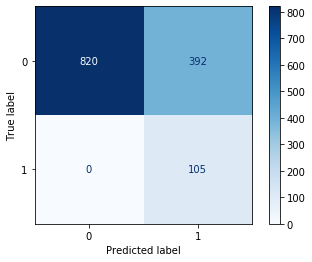

Accuracy :  0.7023538344722855
Sensitivity :  1.0
Specificity :  0.6765676567656765
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.68      1.00      0.81      0.82      0.65      1212
          1       0.21      1.00      0.68      0.35      0.82      0.70       105

avg / total       0.94      0.70      0.97      0.77      0.82      0.66      1317



In [30]:
#cm = confusion_matrix(y_train_adasyn,y_pred)
cm = confusion_matrix(y_train,y_pred_modelo1_rev2)

#plot_confusion_matrix(rf_1,X_train_adasyn,y_train_adasyn,cmap=plt.cm.Blues)
plot_confusion_matrix(rf_2,newX_train_modelo1_rev2,y_train,cmap=plt.cm.Blues)

plt.show()

accuracy1=(cm[0,0]+cm[1,1])/(cm[1,0]+cm[1,1]+cm[0,0]+cm[0,1])
print ('Accuracy : ', accuracy1)

sensitivity1 = cm[1,1]/(cm[1,0]+cm[1,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm[0,0]/(cm[0,0]+cm[0,1])  #ojo, creo que está al revés esto
print('Specificity : ', specificity1)

from imblearn.metrics import classification_report_imbalanced

print(classification_report_imbalanced(y_train, y_pred_modelo1_rev2))

### Prestaciones en test

In [31]:
#modify NaNs in X_test

feature_names = ['Age','Weight','Size','IMC','Creatinine','Cystatin','HDL','LDL','Triglyciredes','GOT','GPT','GGT','Albuminuria','Ferritin','HOMA','Insulin','Blood_Glucose','Glycated-HB','PCR','Vitamin-D','TAS','TAD','Date']

X_test_modelo1_rev2 = pd.DataFrame(X_test[:,1,:],columns = feature_names[:-1])

X_test_modelo1_rev2 = X_test_modelo1_rev2.drop('Blood_Glucose',axis = 1)
X_test_modelo1_rev2 = X_test_modelo1_rev2.drop('Glycated-HB',axis = 1)

#impute

X_test_modelo1_rev2 = X_test_modelo1_rev2.fillna(newX_train_modelo1_rev2.median())
#newX_test = np.concatenate((X_test_2, Prob_test[:,None]), axis=1)
newX_test_modelo1_rev2 = np.concatenate((X_test_modelo1_rev2, Prob_test_without_BG_HB[:,np.newaxis]), axis=1)

y_pred_test_modelo1_rev2 = rf_2.predict(newX_test_modelo1_rev2)
y_pred_test_prob_modelo1_rev2 = rf_2.predict_proba(newX_test_modelo1_rev2)


plot_confusion_matrix(rf_2,newX_test_modelo1_rev2,y_test,cmap=plt.cm.Blues)

plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'median'

In [ ]:
cm1 = confusion_matrix(y_test,y_pred_test_modelo1_rev2)

accuracy1=(cm1[0,0]+cm1[1,1])/(cm1[0,0]+cm1[0,1]+cm1[1,0]+cm1[1,1])
print ('Accuracy : ', accuracy1)

specificity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Specificity : ', specificity1 )

sensitivity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Sensitivity : ', sensitivity1)

# Aplicamos el modelo eliminando las variables Vitamin-D, HOMA e Insulin

# 1. PREPROCESADO

In [ ]:
def data_nan_review_analysis_1(X):
    """
    Function that takes as input a matrix with pats and features for one review, and gets back
    X_train_rev_imputed,pats_to_drop,feature_to_drop,imputation_data
    """
    feature_names = ['Age','Weight','Size','IMC','Creatinine','Cystatin','HDL','LDL','Triglyciredes','GOT','GPT','GGT','Albuminuria','Ferritin','HOMA','Insulin','Blood_Glucose','Glycated-HB','PCR','Vitamin-D','TAS','TAD','Date']
    
    df = pd.DataFrame(X,columns = feature_names[:-1]) #convert it to df #delete date [:-1]
    
    print(df.columns)
    df = df.drop('HOMA',axis = 1)
    df = df.drop('Insulin',axis = 1)
    df = df.drop('Blood_Glucose',axis = 1)
    df = df.drop('Glycated-HB',axis = 1)
    df = df.drop('Vitamin-D',axis = 1)
    
    
    
    #initialize vars to return
    X_train_rev_imputed = []
    pats_to_drop = []
    feature_to_drop = []
    imputation_data = []
    #check number of NaNs per feature
    
    for index,value in enumerate (df.isnull().sum()):
        if value !=0:
            print(df.columns[index],value)
            
    #Drop features: Blood_Glucose and Glycated_HB
    

    ##reemplazar cada valor por la mediana 
    
    X_train_rev_imputed = df.fillna(df.median()) 
    
    return X_train_rev_imputed,pats_to_drop,feature_to_drop,imputation_data

def imputing_data_1(X):
    """ 
    Function that check data with nans and replace them with appropriate imputation
    """
    X_train_aux = X_train.copy()
    num_review = X_train_aux.shape[1]
    
    X_train_imp = []
    
    #run over the reviews and get the X_train_imputed, pats_to_drop, feature_to_drop, and imputation values
    for i in range(3):
        print("review",i)
        print("----------")
        X_train_rev_imputed,pats_to_drop,feature_to_drop,imputation_data = data_nan_review_analysis_1(X_train_aux[:,i,:])
        print("----------")
        print("----------")
        
        X_train_imp.append(X_train_rev_imputed)
        
    return X_train_imp

In [ ]:
X_train_sin_NaN_modelo2_rev2_imputing = imputing_data_1(X_train)

In [ ]:
#Get the second review

X_train_sin_NaN_modelo2_rev2 = X_train_sin_NaN_modelo2_rev2_imputing[1]

In [ ]:
newX_train_modelo2_rev2 = np.concatenate((X_train_sin_NaN_modelo2_rev2, Prob_train_1_without_BG_HB_VD_Ins_HOMA[:,np.newaxis]), axis=1)

# 2. PREDICCIÓN

## 2.1 Random Forest

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,8,10,12,14,16,18,20]
# Create the random grid
random_grid = {'max_features': max_features,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,}
print(random_grid)

In [ ]:
# First create the base model to tune
rf_11 = BalancedRandomForestClassifier(n_estimators=50, criterion='gini',  
                   bootstrap=True, oob_score=False, class_weight = 'balanced_subsample')

In [ ]:
from sklearn.model_selection import GridSearchCV
# Use the random grid to search for best hyperparameters
# Grid search of parameters, using 7 fold cross validation,

grid_random = GridSearchCV(rf_11, random_grid, cv=7 , n_jobs = -1, verbose = 5)

In [ ]:
# Fit the random search model
grid_random.fit(newX_train_1, y_train)

In [ ]:
grid_random.best_params_

### Rebalancea dentro de cada árbol

In [ ]:
rf_22 = BalancedRandomForestClassifier(n_estimators=5000, criterion='gini', max_features = grid_random.best_params_['max_features'],
                min_samples_leaf = grid_random.best_params_['min_samples_leaf'], min_samples_split = grid_random.best_params_['min_samples_split'],    
                   bootstrap=True, oob_score=False, class_weight = 'balanced_subsample')

In [ ]:
rf_22.fit(newX_train_modelo2_rev2, y_train)

In [ ]:
y_pred_modelo2_rev2 = rf_22.predict(newX_train_modelo2_rev2)
y_pred_1_prob_modelo2_rev2 = rf_22.predict_proba(newX_train_modelo2_rev2)

## 2.2 Calibración de la probabilidad

In [ ]:
'''from sklearn.calibration import CalibratedClassifierCV

base_clf = BalancedRandomForestClassifier(n_estimators=50, criterion='gini', max_features = grid_random.best_params_['max_features'],
                min_samples_leaf = grid_random.best_params_['min_samples_leaf'], min_samples_split = grid_random.best_params_['min_samples_split'],    
                   bootstrap=True, oob_score=False, class_weight = 'balanced_subsample')

#vamos a calibrar training
calibrated_clf = CalibratedClassifierCV(base_estimator=rf_22,cv='prefit', method = 'sigmoid',ensemble = False)

calibrated_clf.fit(X_train_11, y_train)'''

In [ ]:
'''#calibrated_clf.
from sklearn.calibration import calibration_curve

feature_names = ['Age','Weight','Size','IMC','Creatinine','Cystatin','HDL','LDL','Triglyciredes','GOT','GPT','GGT','Albuminuria','Ferritin','HOMA','Insulin','Blood_Glucose','Glycated-HB','PCR','Vitamin-D','TAS','TAD','Date']

X_test_1 = pd.DataFrame(X_test[:,0,:],columns = feature_names[:-1])

X_test_1 = X_test_1.drop('Blood_Glucose',axis = 1)
X_test_1 = X_test_1.drop('Glycated-HB',axis = 1)
X_test_1 = X_test_1.drop('HOMA',axis = 1)
X_test_1 = X_test_1.drop('Insulin',axis = 1)
X_test_1 = X_test_1.drop('Vitamin-D',axis = 1)

X_test_1 = X_test_1.fillna(X_train_1.median())


y_pred_cali = calibrated_clf.predict_proba(X_test_1)[:,1]

y_train_cali = calibrated_clf.predict_proba(X_train_11)[:,1]

fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_pred_cali, n_bins=10)
fraction_of_positives_train, mean_predicted_value_train = calibration_curve(y_train, y_train_cali, n_bins=10)

plt.figure()
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.plot(mean_predicted_value, fraction_of_positives, "s-")
plt.plot(mean_predicted_value_train, fraction_of_positives_train, "^-")


plt.figure()
plt.hist(y_pred_cali, range=(0, 1), bins=10,histtype="step", lw=2)
plt.hist(y_train_cali, range=(0, 1), bins=10,histtype="step", lw=2)


plt.hist(rf_22.predict_proba(X_train_11)[:,1],bins = 10,histtype='step')'''

## 2.3 Prestaciones

### Prestaciones en train

In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [ ]:
cm = confusion_matrix(y_train,y_pred_modelo2_rev2)
print(cm)

#plot_confusion_matrix(rf_1,X_train_adasyn,y_train_adasyn,cmap=plt.cm.Blues)
plot_confusion_matrix(rf_22,newX_train_modelo2_rev2,y_train,cmap=plt.cm.Blues)

plt.show()

accuracy1=(cm[0,0]+cm[1,1])/(cm[1,0]+cm[1,1]+cm[0,0]+cm[0,1])
print ('Accuracy : ', accuracy1)

sensitivity1 = cm[1,1]/(cm[1,0]+cm[1,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm[0,0]/(cm[0,0]+cm[0,1])
print('Specificity : ', specificity1)


from sklearn.metrics import roc_curve, auc
from sklearn.metrics import plot_roc_curve

plot_roc_curve(rf_22, newX_train_1, y_train)
plt.show()

### Prestaciones en test

In [ ]:
#modify NaNs in X_test

feature_names = ['Age','Weight','Size','IMC','Creatinine','Cystatin','HDL','LDL','Triglyciredes','GOT','GPT','GGT','Albuminuria','Ferritin','HOMA','Insulin','Blood_Glucose','Glycated-HB','PCR','Vitamin-D','TAS','TAD','Date']

X_test_modelo2_rev2 = pd.DataFrame(X_test[:,1,:],columns = feature_names[:-1])

X_test_modelo2_rev2 = X_test_modelo2_rev2.drop('Blood_Glucose',axis = 1)
X_test_modelo2_rev2 = X_test_modelo2_rev2.drop('Glycated-HB',axis = 1)
X_test_modelo2_rev2 = X_test_modelo2_rev2.drop('HOMA',axis = 1)
X_test_modelo2_rev2 = X_test_modelo2_rev2.drop('Insulin',axis = 1)
X_test_modelo2_rev2 = X_test_modelo2_rev2.drop('Vitamin-D',axis = 1)

#impute

X_test_modelo2_rev2 = X_test_modelo2_rev2.fillna(newX_train_modelo2_rev2.median())
newX_test_modelo2_rev2 = np.concatenate((X_test_modelo2_rev2, Prob_test_1_without_BG_HB_VD_Ins_HOMA[:,np.newaxis]), axis=1)

y_pred_test_modelo2_rev2 = rf_22.predict(newX_test_modelo2_rev2)
y_pred_test_modelo2_rev2 = rf_22.predict_proba(newX_test_modelo2_rev2) #Probabilidad de pertenecer a cada clase

plot_confusion_matrix(rf_22,newX_test_modelo2_rev2,y_test,cmap=plt.cm.Blues)

plt.show()

In [ ]:
cm1 = confusion_matrix(y_test,y_pred_test)
print(cm1)

accuracy1=(cm1[0,0]+cm1[1,1])/(cm[1,0]+cm[1,1]+cm[0,0]+cm[0,1])
print ('Accuracy : ', accuracy1)

sensitivity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Specificity : ', specificity1)


from sklearn.metrics import roc_curve, auc
from sklearn.metrics import plot_roc_curve

plot_roc_curve(rf_22, newX_test_modelo2_rev2, y_test)
plt.show()